In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def region_of_interest(img, vertices, invert=False):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    Added option: Invert=True will return an image with the area in the vertices set to black
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    if invert:
        mask = mask + 255
        val = 0
    else:
        val = 255
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (val,) * channel_count
    else:
        ignore_mask_color = val
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):

    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)


    binary_output = np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    
    return binary

def get_calib_objects(folder, col, row):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((row*col,3), np.float32)
    objp[:,:2] = np.mgrid[0:col, 0:row].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(folder + r'/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (col, row), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (col, row), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            cv2.imshow('img', img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    return objpoints, imgpoints

# src/dest for perspective tranformation
src = np.float32([[530, 500], [774, 500], [1020, 650], [325, 650]])
dst = np.float32([[305,400], [1015, 400], [1015, 650], [305, 650]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [3]:
def merge_results(warped, undist, left_fit, right_fit):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def get_curve(lefty, leftx, righty, rightx):
    # Define conversions in x and y from pixels space to meters
    left_max = np.max(lefty)
    right_max = np.max(righty)
    y_eval = np.max([left_max, right_max])
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad
    # Example values: 632.1 m    626.2 m

def get_fit_window(binary_warped, nwindows=9, plot=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


# Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
        # Generate x and y values for plotting
    if plot:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    return leftx, lefty, left_fit, left_lane_inds, rightx, righty, right_fit, right_lane_inds, out_img


def get_fit_no_window(binary_warped, left_fit, right_fit, plot=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    if plot:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    return leftx, lefty, left_fit, rightx, righty, right_fit

In [4]:
class Lane():
    def __init__(self):
        # track if previous lane looked good
        self.on_lane = False

In [5]:
# do camera calibration
obj_points, img_points = get_calib_objects(r'camera_cal', 9, 6)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (1280, 720),None,None)
# create undistort image flow
# load test images (undistort, etc)
# mask test images
# roughly find lane lanes
# project image to top down
# find lane equations
# project lane equations back to original image
# repeat on video

In [6]:
def image_pipeline(img, mtx, dist, M, Minv, stage='all'):
    im_shape = img.shape
    
    # remove distortion due to camera
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if stage=='undist':
        print('returning undistorted image')
        return undist
    
    
# Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
# I found that doing the thresholding before perspective changes gave better results
    test_img = undist
    gradx = abs_sobel_thresh(test_img, orient='x', sobel_kernel=ksize, thresh=(20, 120))
    grady = abs_sobel_thresh(test_img, orient='y', sobel_kernel=ksize, thresh=(20, 120))
    mag_binary = mag_thresh(test_img, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(test_img, sobel_kernel=ksize, thresh=(0, 1.2))
    hls_binary = hls_select(test_img, thresh=(90, 255))
    if stage=='binary':
        print("returning dict of x, y, mag, dir, hls images")
        return {'x': gradx, 'y': grady, 'mag': mag_binary, 'dir': dir_binary, 'hls': hls_binary}
# change to top down view
    gradx = cv2.warpPerspective(gradx, M, (1280, 720))
    grady = cv2.warpPerspective(grady, M, (1280, 720))
    mag_binary = cv2.warpPerspective(mag_binary, M, (1280, 720))
    dir_binary = cv2.warpPerspective(dir_binary, M, (1280, 720))
    hls_binary = cv2.warpPerspective(hls_binary, M, (1280, 720))
    if stage=='warped_binary':
        print("returning dict of warped x, y, mag, dir, hls images")
        return {'x': gradx, 'y': grady, 'mag': mag_binary, 'dir': dir_binary, 'hls': hls_binary}
    
    combined = np.zeros_like(gradx)
#combined[((mag_binary == 1) & (dir_binary == 1) & (hls_binary == 1))] = 1
    combined[(((hls_binary == 1) | ((gradx == 1) & (grady == 1))) & (dir_binary == 1))] = 1
    #combined[(((hls_binary == 1) | (gradx == 1)) & (dir_binary == 1))] = 1
    if stage=='combined':
        print("returning combinded warped binary")
        return combined

    # mask off edges
    vertices2 = np.array([[(100,im_shape[0]),(100, 0), (1180, 0), (1180,im_shape[0])]], dtype=np.int32)
    vertices3 = np.array([[(500,im_shape[0]),(500, 0), (900, 0), (900,im_shape[0])]], dtype=np.int32)
    masked1=region_of_interest(combined, vertices2)
    
    masked2=region_of_interest(masked1, vertices3, invert=True)
    if stage=='masked1':
        print("returning masked warped binary")
        return masked1
    elif stage=='masked2':
        print("returning masked2 warped binary")
        return masked2
    if LeftLane.on_lane == True and RightLane.on_lane == True:
        # find curve, starting with previous curve
        leftx, lefty, left_fit, rightx, righty, right_fit = get_fit_no_window(masked2, LeftLane.last_fit, RightLane.last_fit)
        if np.max(leftx) < np.min(rightx):
            LeftLane.on_lane = True
            RightLane.on_lane = True
            LeftLane.last_fit = left_fit
            RightLane.last_fit = right_fit
        else:
            LeftLane.on_lane = False
            RightLane.on_lane = False
            left_fit = LeftLane.last_fit
            right_fit = RightLane.last_fit
    else:
        # find curve, more rigorous
        leftx, lefty, left_fit,left_lane_inds, rightx, righty, right_fit, right_lane_inds, out_img = get_fit_window(masked2, nwindows=9)
        if np.max(leftx) < np.min(rightx):
            LeftLane.on_lane = True
            RightLane.on_lane = True
            LeftLane.last_fit = left_fit
            RightLane.last_fit = right_fit
        else:
            LeftLane.on_lane = False
            RightLane.on_lane = False            
            left_fit = LeftLane.last_fit
            right_fit = RightLane.last_fit
    # find curve, starting with previous curve
    #leftx, lefty, left_fit, rightx, righty, right_fit = get_fit_no_window(masked, old_left_fit, old_right_fit)
    if stage=='curve plot':
        return out_img
    # add lane lines to undistorted image
    out_img = merge_results(combined, undist, left_fit, right_fit)
    #out_img = masked
    return out_img

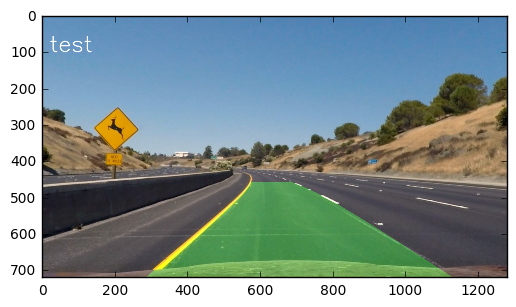

In [19]:
LeftLane=Lane()
RightLane=Lane()
image = mpimg.imread('test_images/test2.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
#binary_warped = image_pipeline(image, mtx, dist, M, Minv, stage='masked2')
binary_warped = image_pipeline(image, mtx, dist, M, Minv)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(binary_warped,'test',(20,100), font, 2,(255,255,255),2,cv2.LINE_AA)
plt.imshow(binary_warped)
plt.show()


In [8]:
left_curverad, right_curverad = get_curve(lefty, leftx, righty, rightx)
print(left_curverad, 'm', right_curverad, 'm')

NameError: name 'lefty' is not defined

In [9]:
LeftLane=Lane()
RightLane=Lane()

In [11]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    result = image_pipeline(image, mtx, dist, M, Minv)
    return result

In [12]:
LeftLane=Lane()
RightLane=Lane()
first_output = 'first.mp4'
clip1 = VideoFileClip("project_video.mp4")
first_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time first_clip.write_videofile(first_output, audio=False)

[MoviePy] >>>> Building video first.mp4
[MoviePy] Writing video first.mp4


100%|█████████▉| 1260/1261 [06:05<00:00,  3.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: first.mp4 

CPU times: user 7min 16s, sys: 1min 16s, total: 8min 33s
Wall time: 6min 6s


In [13]:
LeftLane=Lane()
RightLane=Lane()
first_output = 'challenge_attempt.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
first_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time first_clip.write_videofile(first_output, audio=False)

[MoviePy] >>>> Building video challenge_attempt.mp4
[MoviePy] Writing video challenge_attempt.mp4


100%|██████████| 485/485 [02:27<00:00,  2.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_attempt.mp4 

CPU times: user 2min 48s, sys: 30.8 s, total: 3min 19s
Wall time: 2min 28s


In [ ]:
#to do - add curve/location to video
#finish writeup